In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt

In [19]:
noise_variance = 0.1
desired_rates = np.array([20., 2., 0.1, 1., 1., 0,0,0,0,0,0,0,0,0,0,0])
initial_states = [
    [1, 0, 0], [1, 16, 47], [1, 10,  10], [1,  7, 40],  
    [1,  7, 87], [1, 16, 47], [ 1,  8, 72], [1, 81, 7 ], 
    [1, 79, 24], [1, 29,  5], [ 1, 77, 32], [1, 94, 78],
    [1, 44, 10]
]
initial_states = [np.array([arr]) for arr in initial_states]
n_species = 3

In [20]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=["DA", "MA", "A"])
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[1]])) # MA -> MA + A translation
    sys.add_fusion("MA", "A", "A", np.array([desired_rates[2]])) # MA + A -> A regulation
    sys.add_decay("A", np.array([desired_rates[3]])) # A -> 0 protein decay
    sys.add_decay("MA", np.array([desired_rates[4]])) # MA -> 0 mRNA decay
    return sys

def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species)
    bfc.add_fission(0, 0, 1) # DA -> DA + MA, transcription
    bfc.add_fission(1, 1, 2) # MA -> MA + A, translation
    bfc.add_fusion(1, 2, 2)  # MA + A -> A, regulation
    bfc.add_decay(1) # MA -> 0, decay
    bfc.add_decay(2) # A -> 0, decay
    
    # respective backwards reactions
    bfc.add_fusion(0, 1, 0)  # DA + MA -> DA, nope
    
    # some more stuff
    bfc.add_conversion(0, 1) # DA -> MA, nope
    bfc.add_conversion(1, 0) # MA -> DA, nope
    
    bfc.add_conversion(0, 2) # DA -> A, nope
    bfc.add_conversion(2, 0) # A -> DA, nope
    
    bfc.add_conversion(1, 2) # MA -> A, nope
    bfc.add_conversion(2, 1) # A -> MA, nope
    
    bfc.add_fusion(0, 2, 1) # DA + A -> MA, nope
    bfc.add_fission(1, 0, 2) # MA -> DA + A, nope
    
    bfc.add_fusion(0, 1, 2) # DA + MA -> A, nope
    bfc.add_fission(2, 0, 1) # A -> DA + MA, nope
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

def plot_cv_results(cv, mainscore=0, best_params_ix_l1=1.):
    xs = {}
    ys = {}
    allys = {}
    for r in cv.result:
        l1_ratio = r['l1_ratio']
        if len(r['scores']) > 0:
            if l1_ratio in xs.keys():
                xs[l1_ratio].append(r['alpha'])
                ys[l1_ratio].append(r['scores'][mainscore])
                allys[l1_ratio].append(r['scores'])
            else:
                xs[l1_ratio] = [r['alpha']]
                ys[l1_ratio] = [r['scores'][mainscore]]
                allys[l1_ratio] = [r['scores']]
    f, ax = plt.subplots(figsize=(20, 20))
    for l1_ratio in xs.keys():
        l1xs = np.array(xs[l1_ratio])
        l1ys = np.array(ys[l1_ratio])
        l1allys = np.array([np.array(arr) for arr in allys[l1_ratio]]).T
        sorts = np.argsort(l1xs)
        l1xs = l1xs[sorts]
        l1ys = l1ys[sorts]
        
        l1allys = [arr[sorts] for arr in l1allys]
        if l1_ratio == best_params_ix_l1 or best_params_ix_l1 is None:
            ax.plot(l1xs, -l1ys, label='score l1={}'.format(l1_ratio))
            
            for ix, _ys in enumerate(l1allys):
                if np.argmin(-_ys) != 0:
                    # print("found one: {} with argmin {}".format(ix, np.argmin(_ys)))
                    pass
                # ax.plot(l1xs, -_ys, label='test set {}'.format(ix))
                pass
    f.suptitle('Cross-validation scores')
    ax.set_ylabel('score')
    ax.set_xlabel('$\\alpha$')
    plt.legend()
    plt.show()
def plot_rates_bar(desired_rates, estimated_rates):
    assert len(desired_rates) == len(estimated_rates)
    N = len(desired_rates)
    ind = np.arange(N)
    width = .35
    fig, ax = plt.subplots()
    bar1 = ax.bar(ind, desired_rates, width, color='blue')
    bar2 = ax.bar(ind+width, estimated_rates, width, color='green')
    ax.set_xticks(ind + width / 2)
    ax.legend((bar1[0], bar2[0]), ('Desired', 'Estimated'))
    ax.set_xticklabels(["{}".format(i) for i in ind])
    plt.show()
def best_params(cv, scoreidx=None):
    current_best_score = -1
    alpha = -1
    l1_ratio = -1
    
    for r in cv.result:
        if len(r['scores']) > 0:
            if scoreidx is None:
                currscore = np.mean(r['scores'])
            else:
                currscore = r['scores'][scoreidx]
            if current_best_score >= 0:
                if -currscore < current_best_score:
                    current_best_score = -currscore
                    alpha = r['alpha']
                    l1_ratio = r['l1_ratio']
            else:
                current_best_score = -currscore
                alpha = r['alpha']
                l1_ratio = r['l1_ratio']
    return alpha, l1_ratio, current_best_score
def do_the_cv(analysis, n, alphas, l1_ratios, tol=1e-12, solvetol=1e-15, plot_cv_for=None, best_params_ix=None,
              best_params_ix_l1=None):
    cv_n = analysis.elastic_net(n, alphas, l1_ratios, tol=tol)
    if plot_cv_for is not None:
        plot_cv_results(cv_n, mainscore=plot_cv_for, best_params_ix_l1=best_params_ix_l1)
    alpha, l1_ratio, score = best_params(cv_n, best_params_ix)
    print("params: alpha={}, l1={} with corresponding score {}".format(alpha, l1_ratio, score))
    cutoff = 1e-8
    rates = analysis.solve(n, alpha, l1_ratio, tol=solvetol, recompute=True)
    rates[np.where(rates <= cutoff)] = 0
    return rates

[KMC] [2017-12-04 14:35:23] [INFO] Simulate for 4000 steps


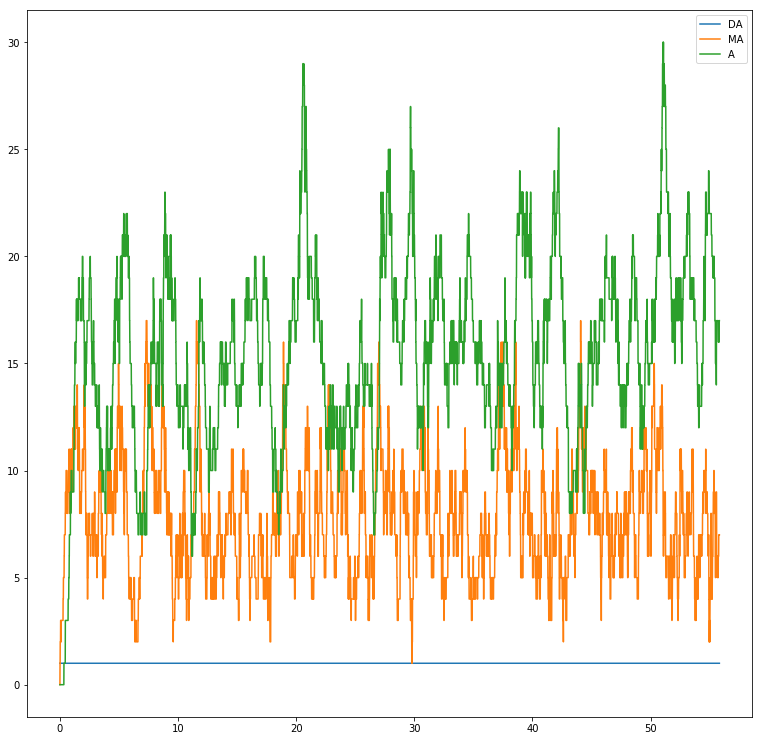

In [21]:
system = set_up_system(initial_states[0])
system.simulate(4000)
counts, times = system.convert_events_to_time_series2(0.001)
counts_da = counts[:,0,0]
counts_ma = counts[:,0,1]
counts_a = counts[:,0,2]
plt.plot(times, counts_da, label="DA")
plt.plot(times, counts_ma, label="MA")
plt.plot(times, counts_a, label="A")
plt.legend(loc="best")
plt.show()

In [5]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                recompute=False, recompute_traj=False, fname_prefix='self_regulation', 
                                fname_postfix='1',  n_species=n_species, target_n_counts=500, timestep=5e-4,
                                ld_derivative_config=ld_derivative_config)

In [6]:
analysis.obtain_lma_trajectories(130, noise_variance=noise_variance, 
                                 alphas=np.linspace(0.1, 10000, num=8), verbose=False, 
                                 atol=5e-5, maxit=500)

obtaining derivative for species [0 1 2]
Dont have derivative (got 0 but need 3)
got 500 counts (and 500 corresp. time steps), dt= 0.26


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=10000.0 to be best with a difference of 5.712695201966525e+129 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

found alpha=8571.442857142856 to be best with a difference of 2.5713227202723163e+193 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


found alpha=8571.442857142856 to be best with a difference of 3.918446384263999e+289 between mse and variance


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Text(value=''), IntProgress(value=0)))

Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


Box(children=(Label(value='Progress: 0/0 it, atol=?/5e-05, rtol=?/None'),))

/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:322: RuntimeWarning: overflow encountered in square
  E_n.setdiag(midpoints_diff * (1. / np.sqrt(np.diff(u) ** 2.0 + epsilon)))
/home/chris/workspace/readdy_learn/readdy_learn/analyze/derivative.py:345: RuntimeWarning: invalid value encountered in double_scalars
  relative_change = np.linalg.norm(s[0]) / np.linalg.norm(u)


KeyboardInterrupt: 